Thank you: https://www.kaggle.com/sayakdasgupta/introduction-to-gans-on-fashion-mnist-dataset/ for learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
for dirname, _, filenames in os.walk('./data/fashionmnist'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/fashionmnist/t10k-images-idx3-ubyte
./data/fashionmnist/fashion-mnist_test.csv
./data/fashionmnist/t10k-labels-idx1-ubyte
./data/fashionmnist/train-images-idx3-ubyte
./data/fashionmnist/fashion-mnist_train.csv
./data/fashionmnist/train-labels-idx1-ubyte


In [3]:
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
import tensorflow as tf


Using TensorFlow backend.


In [30]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 482904873889227450
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5148194205131914782
physical_device_desc: "device: XLA_CPU device"
]


In [4]:
train_data = pd.read_csv('./data/fashionmnist/fashion-mnist_train.csv')
# train_data.head()

In [5]:
X_train = train_data.drop('label', axis=1)
# X_train.head()

In [6]:
X_train=X_train.values
print(X_train.shape)

(60000, 784)


In [7]:
X_train = X_train.reshape(-1, 28, 28, 1) # what
print(X_train.shape)
# a number of image, row, column, ??

(60000, 28, 28, 1)


In [8]:
print(X_train.ndim)

4


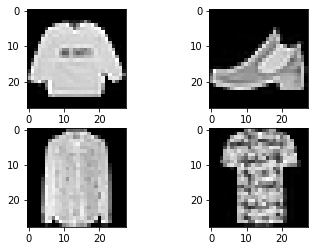

In [9]:
fig,axe = plt.subplots(2, 2)
idx = 0
for i in range(2):
  for j in range(2):
    axe[i,j].imshow(X_train[idx].reshape(28, 28), cmap='gray')
    idx+=1

In [10]:
X_train = X_train.astype('float32')

In [11]:
# The pixel data ranges from 0 to 255 hence dividing each pixel by 255, ie, normalizing the data such that the range is within 0 to 1
X_train = X_train/255
# Note after normalizing it is multiplied with 2 and subtracted from 1 such that it ranges from (-1, 1) because in DCGANs the last layer generative model activation is tanh which range is (-1, 1) inlike sigmoid ranging (0,1)
X_train = X_train*2-1 

In [12]:
print(X_train.max(), X_train.min())

1.0 -1.0


Simple GAN Model <br>
Generative part

In [13]:
generator = Sequential()

generator.add(Dense(512, input_shape=[100])) # what
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

generator.add(Dense(128))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

generator.add(Dense(784))
generator.add(Reshape([28,28,1]))

In [14]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               51712     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

In [15]:
# Discriminatory part
discriminator = Sequential()
discriminator.add(Dense(1, input_shape=[28, 28, 1]))
discriminator.add(Flatten()) # What is Flatten
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5)) # What is Dropout
discriminator.add(Dense(64))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5)) # What is Dropout
discriminator.add(Dense(1,activation='sigmoid'))

In [16]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 28, 28, 1)         2         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               200960    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 128)              

1. Compiling the discriminator layer <br>
2. Compiling the GAN <br>
NOTE: the generator layer is not compiled seperately because it gets trained as part of the combined model but training the discriminator is necessary because it is trained before the combined model.

In [17]:
GAN = Sequential([generator, discriminator])
discriminator.compile(optimizer='adam', loss='binary_crossentropy')
discriminator.trainable = False

In [18]:
GAN.compile(optimizer='adam', loss='binary_crossentropy')

In [19]:
GAN.layers

In [20]:
GAN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         320656    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 242179    
Total params: 562,835
Trainable params: 318,864
Non-trainable params: 243,971
_________________________________________________________________


In [21]:
epochs = 30 # what is it ?
batch_size = 100 # what is it ?
noise_shape = 100 # what is it ?

In [ ]:
with tf.device('/device:CPU:0'):
  for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    
    for i in range(X_train.shape[0]//batch_size):
      if (i+1)%50 == 0:
        print(f"\tCurrently on batch number {i+1} of {X_train.shape[0]//batch_size}")
        # what
        noise = np.random.normal(size=[batch_size, noise_shape])
        
        gen_image = generator.predict_on_batch(noise)
        
        train_dataset = X_train[i*batch_size:(i+1)*batch_size]
        
        # training discriminator on real images
        train_label = np.ones(shape=(batch_size, 1))
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(train_dataset, train_label)
        
        # training discriminator on fake images
        train_label=np.zeros(shape=(batch_size, 1))
        d_loss_fake = discriminator.train_on_batch(gen_image,train_label)
        
        # training generator
        noise=np.random.normal(size=[batch_size, noise_shape])
        train_label=np.ones(shape=(batch_size, 1))
        discriminator.trainable = False
        d_g_loss_batch = GAN.train_on_batch(noise, train_label)
      #plotting generated images at the start and then after every 10 epoch
#       if epoch % 10 == 0:
#         samples = 10
#         x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))
        
#         for k in range(samples):
#           plt.subplot(2, 5, k+1)
#           plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
#           plt.xticks([])
#           plt.yticks([])
#         plt.tight_layout()
#         plt.show()

In [33]:
noise=np.random.normal(size=[10,noise_shape])
gen_image = generator.predict(noise)
# noise generated using np.random.normal is given to as input to the generator. In the next step the generator produces batches of meaningful alike image from the random distribution.

Text(0.5, 1.0, 'How the noise looks')

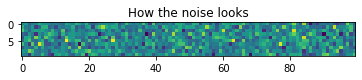

In [34]:
plt.imshow(noise)
plt.title('How the noise looks')

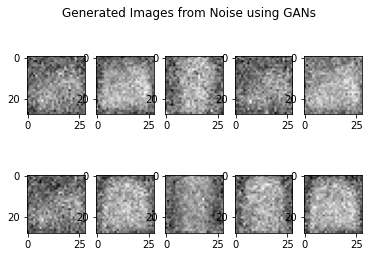

In [36]:
fig,axe=plt.subplots(2,5)
fig.suptitle('Generated Images from Noise using GANs')
idx=0
for i in range(2):
    for j in range(5):
         axe[i,j].imshow(gen_image[idx].reshape(28,28),cmap='gray')
         idx+=1